In [ ]:
import os
import numpy as np
import pandas as pd
import random
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from IPython.core.display import HTML,display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import re
import timeit
import gc

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Project NLP

/content/drive/.shortcut-targets-by-id/1O9F6DXi_XG3MRqGCdIXq2iJY5O0gCxq2/Project NLP


In [ ]:
file_name = '/content/drive/MyDrive/Project NLP/dataset berita.csv'
df_data = pd.read_csv(file_name, sep=';')
df_data.head().append(df_data.tail())

,kategori,berita
0,valid,"""Gunung Agung erupsi untuk pertama kali pada 2..."
1,valid,"""Jakarta, CNN Indonesia -- Menteri BUMN Erick ..."
2,valid,"""Dosen Fakultas Kedokteran Hewan IPB, Yusuf Ri..."
3,valid,"""Jakarta - Dua anggota TNI, Serda N dan Serda ..."
4,valid,"""Akui Tembak Jatuh Pesawat Ukraina, Iran Tuai ..."
1095,valid,Kabar yang beredar seputar rencana kenaikan ga...
1096,valid,Kabar yang beredar seputar rencana kenaikan ga...
1097,valid,"Akhir-akhir ini, beredar pemberitaan yang meny..."
1098,valid,Rancangan peraturan pemerintah (RPP) tentang G...
1099,valid,Kabar yang beredar seputar rencana kenaikan ga...


In [ ]:
df_data.isnull().sum()

kategori    0
berita      0
dtype: int64

In [ ]:
df_data['kategori'].value_counts()

valid    622
hoax     478
Name: kategori, dtype: int64

In [ ]:
df_data['text_word_count']=df_data['berita'].apply(lambda x:len(x.split()))

# Data Preparation


In [ ]:
df_data['kategori'] = df_data['kategori'].replace(['valid'],0)
df_data['kategori'] = df_data['kategori'].replace(['hoax'],1)

# Data Visualisation

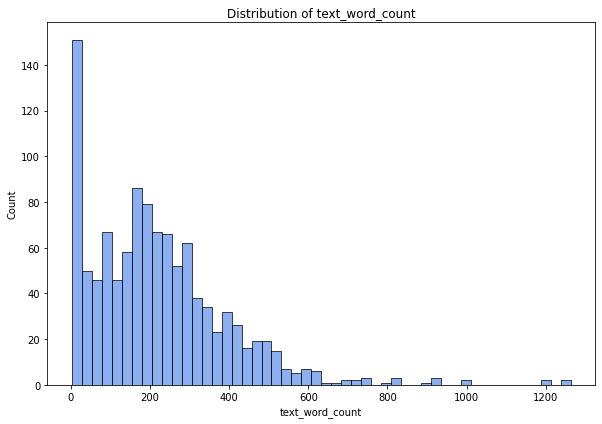

In [ ]:
numerical_feature_cols=['text_word_count']
plt.figure(figsize=(24,6))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df_data,x=col,bins=50,color='#6495ED')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

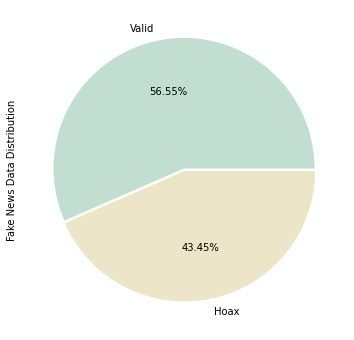

In [ ]:
plt.figure(figsize=(10,6))
colors=['#C2DED1','#ECE5C7']
plt.pie(df_data['kategori'].value_counts(),labels=['Valid','Hoax'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.ylabel('Fake News Data Distribution');

Valid rating WorldCloud

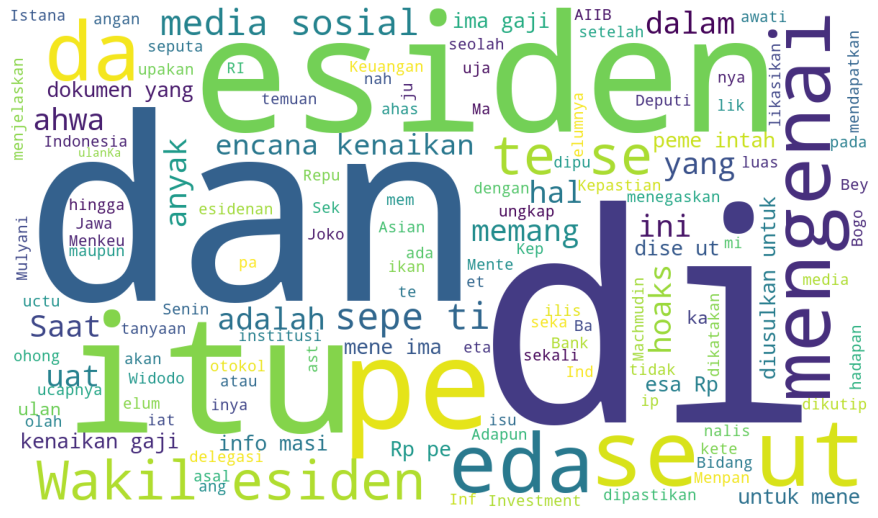

In [ ]:
text_list=df_data.loc[df_data['kategori']==0,'berita'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Hoax Rating World Cloud

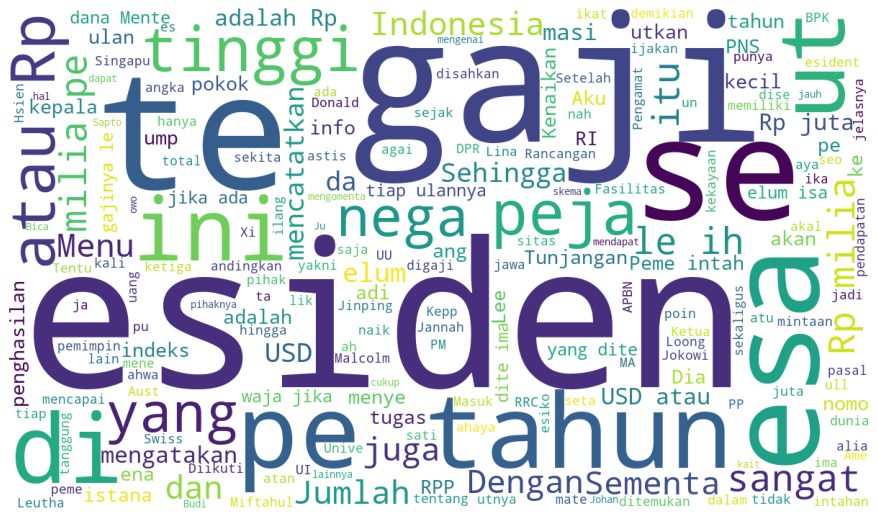

In [ ]:
text_list=df_data.loc[df_data['kategori']==1,'berita'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Data Preprocessing

In [ ]:

xtrain, xtest, ytrain, ytest = train_test_split(df_data['berita'].to_numpy(),df_data['kategori'].to_numpy(),test_size=0.2,stratify=df_data['kategori'].to_numpy())

In [ ]:

Counter(ytrain),Counter(ytest)

(Counter({0: 498, 1: 382}), Counter({0: 124, 1: 96}))

In [ ]:
#
training_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain)).batch(batch_size=20).prefetch(tf.data.AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=20).prefetch(tf.data.AUTOTUNE)

Tokenization & Vectorization

In [ ]:

max_vocab_length=10000

max([len(x.split()) for x in xtrain])

1263

In [ ]:
selected_news_length=round(np.percentile(([len(x.split()) for x in xtrain]),95))
selected_news_length


519

In [ ]:
textVectorizer=layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=selected_news_length
);

textVectorizer.adapt(xtrain)

In [ ]:
textVectorizer(xtrain[0]).shape

TensorShape([519])

Embeding Layer<br>
Di sini setiap kata akan diubah menjadi vektor dence sehingga kata-kata yang memiliki makna serupa memiliki kira-kira. nilai yang sama.

In [ ]:
#embeding layer 
embedding=layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=selected_news_length
)
# here each word will be represented using a 128 dim dense vector

In [ ]:
# shape of each instance after undergoing embedding layer
embedding(textVectorizer(xtrain[0])).shape

TensorShape([519, 128])

# Modeling Result FNN

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.1)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model=keras.models.Model(inputs,outputs,name="model")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


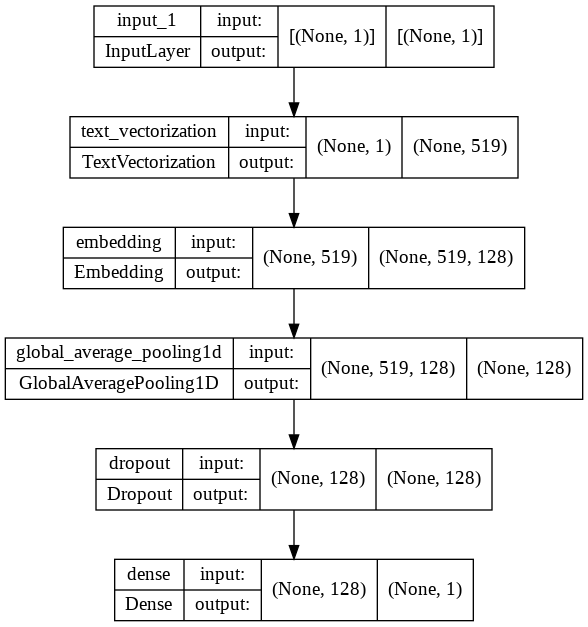

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_history=model.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=50,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/50
44/44 [==============================] - 5s 12ms/step - loss: 0.6876 - accuracy: 0.5625 - val_loss: 0.6807 - val_accuracy: 0.5636
Epoch 2/50
44/44 [==============================] - 0s 8ms/step - loss: 0.6733 - accuracy: 0.5659 - val_loss: 0.6696 - val_accuracy: 0.5636
Epoch 3/50
44/44 [==============================] - 1s 13ms/step - loss: 0.6562 - accuracy: 0.5716 - val_loss: 0.6564 - val_accuracy: 0.5682
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.6353 - accuracy: 0.6841 - val_loss: 0.6421 - val_accuracy: 0.6955
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.6104 - accuracy: 0.7420 - val_loss: 0.6279 - val_accuracy: 0.7318
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.5846 - accuracy: 0.7670 - val_loss: 0.6139 - val_accuracy: 0.7545
Epoch 7/50
44/44 [==============================] - 1s 14ms/step - loss: 0.5579 - accuracy: 0.7875 - val_loss: 0.5993 - val_accuracy: 0.7545
Epoch 8/50
44/

Text(0.5, 1.0, 'Training and validation loss')

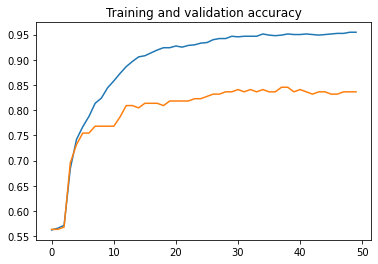

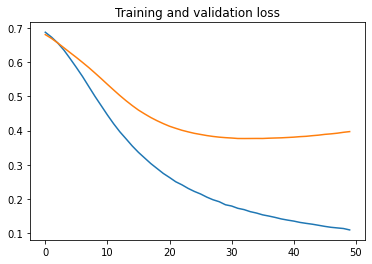

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
train_acc      = model_history.history['accuracy']
val_acc  = model_history.history['val_accuracy']
train_loss     = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs   = range(len(train_acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     train_acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     train_loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
start_time=timeit.default_timer()
model_pred_prob=model.predict(test_dataset)
model_pred=tf.squeeze(tf.round(model_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_accuracy=accuracy_score(ytest,model_pred)
model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(ytest,model_pred,average='weighted')

print("Accuracy : ", model_accuracy,"%")
print("Precision : ", model_precision)
print("Recall : ", model_recall)
print("F1 Score : ", model_f1_score)
print("Time per Instance : ",time_taken_per_instance,"detik")

Accuracy :  0.8363636363636363 %
Precision :  0.8375757575757576
Recall :  0.8363636363636363
F1 Score :  0.8366921135071018
Time per Instance :  0.0008507874863635255 detik


In [ ]:
from sklearn.metrics import confusion_matrix
print('--------------------- confusion matrix  ----------------------------')
print(confusion_matrix(ytest, model_pred))

--------------------- confusion matrix  ----------------------------
[[104  20]
 [ 16  80]]


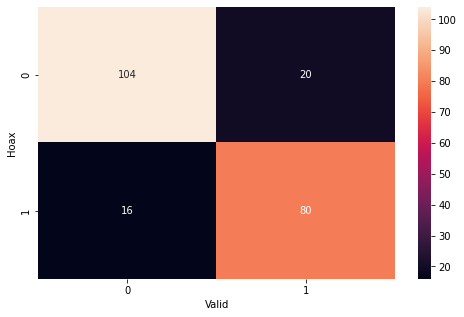

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(ytest, model_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Valid")
plt.ylabel("Hoax")
plt.show()

# Modeling Result MultinomialNB + TFIDFVectorizer

In [ ]:
import nltk
nltk.download('stopwords')
modelNB=Pipeline([
    ('tf-idf',TfidfVectorizer(stop_words = nltk.corpus.stopwords.words('indonesian'))),
    ('clf',MultinomialNB())
])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
modelNB.fit(xtrain,ytrain)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(stop_words=['ada', 'adalah', 'adanya',
                                             'adapun', 'agak', 'agaknya',
                                             'agar', 'akan', 'akankah', 'akhir',
                                             'akhiri', 'akhirnya', 'aku',
                                             'akulah', 'amat', 'amatlah',
                                             'anda', 'andalah', 'antar',
                                             'antara', 'antaranya', 'apa',
                                             'apaan', 'apabila', 'apakah',
                                             'apalagi', 'apatah', 'artinya',
                                             'asal', 'asalkan', ...])),
                ('clf', MultinomialNB())])

In [ ]:
start_time=timeit.default_timer()
modelNB_pred=modelNB.predict(xtest)
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)

model_accuracy=accuracy_score(ytest,modelNB_pred)
model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(ytest,modelNB_pred,average='weighted')

print("Accuracy : ", model_accuracy,"%")
print("Precision : ", model_precision)
print("Recall : ", model_recall)
print("F1 Score : ", model_f1_score)
print("Time per Instance : ",time_taken_per_instance,"detik")

Accuracy :  0.7 %
Precision :  0.7476725521669341
Recall :  0.7
F1 Score :  0.668125539879067
Time per Instance :  0.0001660152272726443 detik


In [ ]:
from sklearn.metrics import confusion_matrix
print('--------------------- confusion matrix  ----------------------------')
print(confusion_matrix(ytest, modelNB_pred))

--------------------- confusion matrix  ----------------------------
[[118   6]
 [ 60  36]]


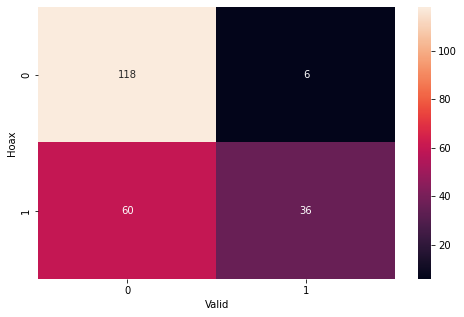

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(ytest, modelNB_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Valid")
plt.ylabel("Hoax")
plt.show()

# LTSM

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
modelx = Sequential()
modelx.add(embedding)
modelx.add(Dropout(0.5))
modelx.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
modelx.add(Dense(1, activation='sigmoid'))

modelx.summary()

In [ ]:
modelx.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])